In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.metrics import confusion_matrix
import matplotlib.patches as mpatches
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from xgboost.sklearn import XGBClassifier
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb
import os
import time
import catboost as cb
from sklearn.preprocessing import OneHotEncoder
from bayes_opt import BayesianOptimization#pip install bayesian-optimization
from sklearn.model_selection import KFold
import copy
from sklearn.preprocessing import LabelEncoder

In [2]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [76]:
#df = reduce_mem_usage(pd.read_csv('train.csv'))
#df_test = reduce_mem_usage(pd.read_csv('test.csv'))
df = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [ ]:
#print(df['acqic'].value_counts(dropna=False, normalize=True).head())
for i,cn in enumerate(df[df.columns]):
    print(df[cn].value_counts(dropna=False, normalize=True).sort_index())
    print("-------------------------------")

In [77]:
#類別轉換
#contp交易類別 csmcu消費地幣別 etymd交易型態 stocn消費地國別 scity hcefg支付形態  ?mchno特店代號
#csmcu 消費地幣別     ovrlt超額註記碼 insfg  分期交易註記ecfg 網路交易註記

#cat_cols = ['contp', 'csmcu', 'etymd', 'stocn', 'scity', 'hcefg', 'csmcu', 'ovrlt', 'insfg', 'ecfg']
cat_cols =  list(df.columns)
cat_cols.remove('fraud_ind')
cat_cols.remove('txkey')
cat_cols.remove('loctm')
cat_cols.remove('locdt')
cat_cols.remove('conam')
for col in cat_cols:
    if col in df.columns:
        le = LabelEncoder()
        le.fit(list(df[col].astype(str).values) + list(df_test[col].astype(str).values))
        df[col] = le.transform(list(df[col].astype(str).values))
        df_test[col] = le.transform(list(df_test[col].astype(str).values)) 

In [19]:
for col in df.columns:
    if(df[col].duplicated().sum() <10):
        print(col)

txkey


In [78]:
import copy
df_backup = copy.copy(df)
df_test_backup = copy.copy(df_test)

這裡重新開始

In [87]:
df = copy.copy(df_backup)
df_test = copy.copy(df_test_backup)

In [65]:
#for col in cat_cols:
#    if col in df.columns:
#        df[col] = df[col].astype('category')
#        df_test[col] = df_test[col].astype('category')     

In [197]:
#若特徵中其中有一個值超過90%
big_top_value_cols = [col for col in df.columns if df[col].value_counts(dropna=False, normalize=True).values[0] > 0.9]
big_top_value_cols_test = [col for col in df_test.columns if df_test[col].value_counts(dropna=False, normalize=True).values[0] > 0.9]
print(big_top_value_cols )

['contp', 'flbmk', 'flg_3dsmk', 'fraud_ind', 'hcefg', 'insfg', 'iterm', 'ovrlt', 'stscd']


In [198]:
print(df.isnull().sum())

acqic        0
bacno        0
cano         0
conam        0
contp        0
csmcu        0
ecfg         0
etymd        0
flbmk        0
flg_3dsmk    0
fraud_ind    0
hcefg        0
insfg        0
iterm        0
locdt        0
loctm        0
mcc          0
mchno        0
ovrlt        0
scity        0
stocn        0
stscd        0
txkey        0
dtype: int64


In [ ]:
#for i,col in enumerate(df[df.columns]):
#    df[col].fillna(-999, inplace=True)

In [88]:
df.columns



Index(['acqic', 'bacno', 'cano', 'conam', 'contp', 'csmcu', 'ecfg', 'etymd',
       'flbmk', 'flg_3dsmk', 'fraud_ind', 'hcefg', 'insfg', 'iterm', 'locdt',
       'loctm', 'mcc', 'mchno', 'ovrlt', 'scity', 'stocn', 'stscd', 'txkey'],
      dtype='object')

In [54]:
by_group_col ='csmcu'
groupby_col =['bacno','cano']
df['V5'] = df[by_group_col] / df.groupby(groupby_col)[by_group_col].transform('mean')
df['V6'] = df[by_group_col] / df.groupby(groupby_col)[by_group_col].transform('std')
df_test['V5'] = df[by_group_col] / df.groupby(groupby_col)[by_group_col].transform('mean')
df_test['V6'] = df[by_group_col] / df.groupby(groupby_col)[by_group_col].transform('std')

print(df.columns)
print(df_test.columns)

Index(['acqic', 'bacno', 'cano', 'conam', 'contp', 'csmcu', 'ecfg', 'etymd',
       'flbmk', 'flg_3dsmk', 'fraud_ind', 'hcefg', 'insfg', 'iterm', 'locdt',
       'loctm', 'mcc', 'mchno', 'ovrlt', 'scity', 'stocn', 'stscd', 'txkey',
       'V5', 'V6'],
      dtype='object')
Index(['acqic', 'bacno', 'cano', 'conam', 'contp', 'csmcu', 'ecfg', 'etymd',
       'flbmk', 'flg_3dsmk', 'hcefg', 'insfg', 'iterm', 'locdt', 'loctm',
       'mcc', 'mchno', 'ovrlt', 'scity', 'stocn', 'stscd', 'txkey', 'V5',
       'V6'],
      dtype='object')


In [ ]:
by_group_col ='ecfg'
groupby_col =['bacno','cano']
df['conam_to_mean_cred'] = df[by_group_col] / df.groupby(groupby_col)[by_group_col].transform('mean')
df['conam_to_std_cred'] = df[by_group_col] / df.groupby(groupby_col)[by_group_col].transform('std')
by_group_col ='csmcu'
groupby_col =['acqic','stocn','scity','mcc','mchno']
df['conam_to_mean_store'] = df[by_group_col] / df.groupby(groupby_col)[by_group_col].transform('mean')
df['conam_to_std_store'] = df[by_group_col] / df.groupby(groupby_col)[by_group_col].transform('std')
groupby_col =['insfg','iterm']
df['conam_to_mean_staging'] = df[by_group_col] / df.groupby(groupby_col)[by_group_col].transform('mean')
df['conam_to_std_staging'] = df[by_group_col] / df.groupby(groupby_col)[by_group_col].transform('std')
groupby_col =['contp','hcefg','etymd']
df['conam_to_mean_trade'] = df[by_group_col] / df.groupby(groupby_col)[by_group_col].transform('mean')
df['conam_to_std_trade'] = df[by_group_col] / df.groupby(groupby_col)[by_group_col].transform('std')

In [ ]:
i = 'fraud_ind'
col_name ='conam_to_mean_store'
cor = np.corrcoef(df[col_name], df[i])[0,1]
df.loc[df['fraud_ind'] == 0].set_index(col_name)[i].fillna(-1).plot(style='.', title=i+" corr= "+str(round(cor,3)), figsize=(15, 3), label="isFraud=0")
df.loc[df['fraud_ind'] == 1].set_index(col_name)[i].fillna(-1).plot(style='.', title=i+" corr= "+str(round(cor,3)), figsize=(15, 3), label="isFraud=1")
#test_transaction.set_index('TransactionDT')[i].plot(style='.', title=i+" corr= "+str(round(cor,3)), figsize=(15, 3))
plt.legend()
plt.show()
i = 'fraud_ind'
col_name ='conam_to_mean_staging'
cor = np.corrcoef(df[col_name], df[i])[0,1]
df.loc[df['fraud_ind'] == 0].set_index(col_name)[i].fillna(-1).plot(style='.', title=i+" corr= "+str(round(cor,3)), figsize=(15, 3), label="isFraud=0")
df.loc[df['fraud_ind'] == 1].set_index(col_name)[i].fillna(-1).plot(style='.', title=i+" corr= "+str(round(cor,3)), figsize=(15, 3), label="isFraud=1")
#test_transaction.set_index('TransactionDT')[i].plot(style='.', title=i+" corr= "+str(round(cor,3)), figsize=(15, 3))
plt.legend()
plt.show()
i = 'fraud_ind'
col_name ='conam_to_mean_cred'
cor = np.corrcoef(df[col_name], df[i])[0,1]
df.loc[df['fraud_ind'] == 0].set_index(col_name)[i].fillna(-1).plot(style='.', title=i+" corr= "+str(round(cor,3)), figsize=(15, 3), label="isFraud=0")
df.loc[df['fraud_ind'] == 1].set_index(col_name)[i].fillna(-1).plot(style='.', title=i+" corr= "+str(round(cor,3)), figsize=(15, 3), label="isFraud=1")
#test_transaction.set_index('TransactionDT')[i].plot(style='.', title=i+" corr= "+str(round(cor,3)), figsize=(15, 3))
plt.legend()
plt.show()
i = 'fraud_ind'
col_name ='conam_to_mean_trade'
cor = np.corrcoef(df[col_name], df[i])[0,1]
df.loc[df['fraud_ind'] == 0].set_index(col_name)[i].fillna(-1).plot(style='.', title=i+" corr= "+str(round(cor,3)), figsize=(15, 3), label="isFraud=0")
df.loc[df['fraud_ind'] == 1].set_index(col_name)[i].fillna(-1).plot(style='.', title=i+" corr= "+str(round(cor,3)), figsize=(15, 3), label="isFraud=1")
#test_transaction.set_index('TransactionDT')[i].plot(style='.', title=i+" corr= "+str(round(cor,3)), figsize=(15, 3))
plt.legend()
plt.show()

In [ ]:
train['time'] = train['TransactionDT'] / (60*60*24) - 9/24

C:\Users\kiwi\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\kiwi\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


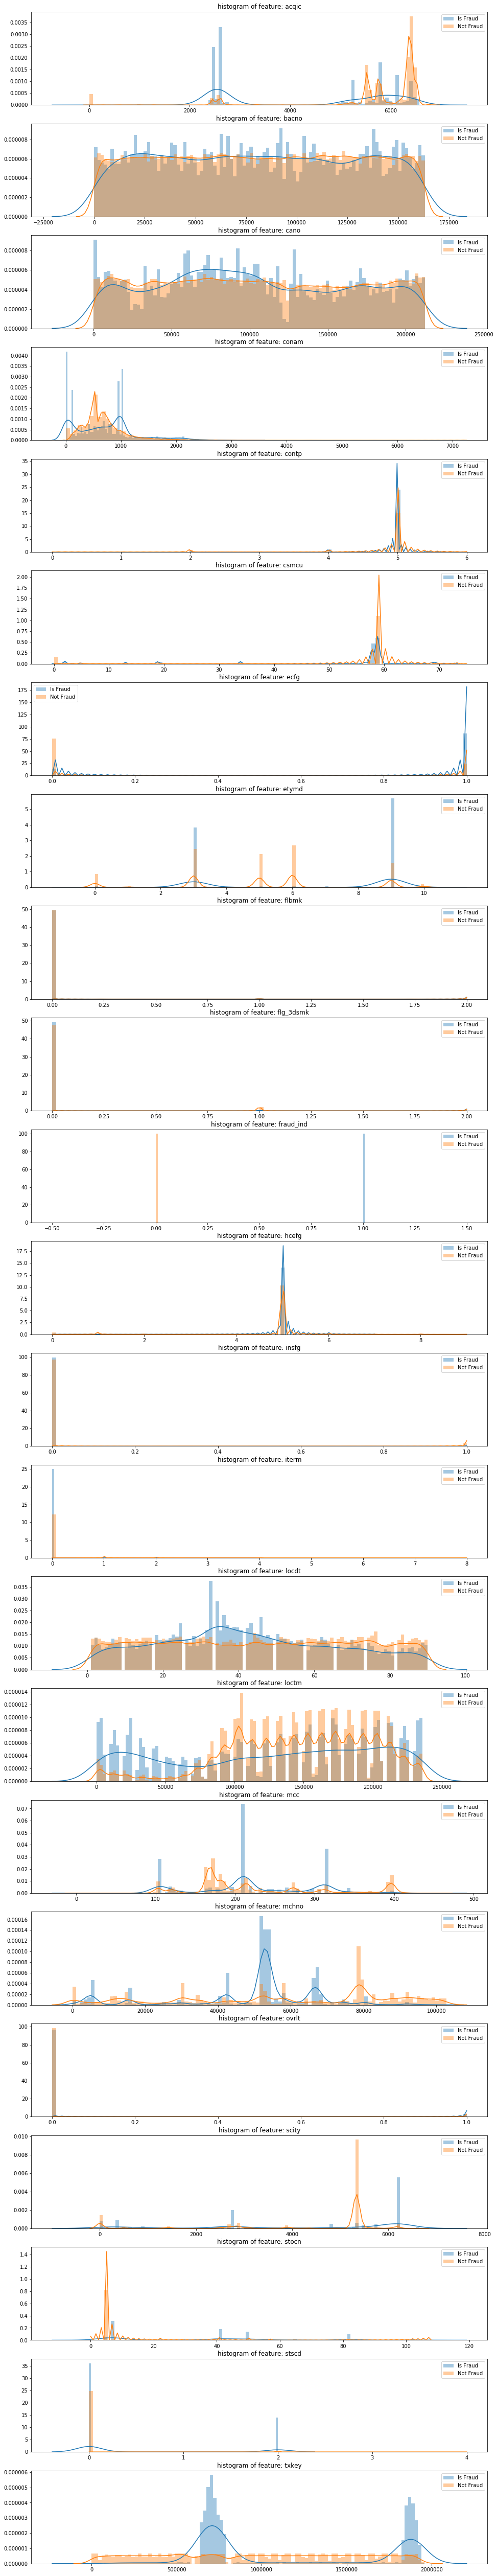

In [80]:
#trainset的資料分布
from matplotlib import gridspec
plt.figure(figsize=(16,30*4))
gs = gridspec.GridSpec(30, 1)#创建20行1列的画布
for i, col  in enumerate(df[df.columns]):    
    ax = plt.subplot(gs[i])
    sns.distplot(df[col][df["fraud_ind"] == 1],label = 'Is Fraud',bins=100)
    sns.distplot(df[col][df["fraud_ind"] == 0],label = 'Not Fraud',bins=100)
    plt.legend();
    ax.set_xlabel('')
    ax.set_title('histogram of feature: ' + str(col))

In [200]:
print('No Frauds', round(df['fraud_ind'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Frauds', round(df['fraud_ind'].value_counts()[1]/len(df) * 100,2), '% of the dataset')
df['fraud_ind'].value_counts()

No Frauds 98.66 % of the dataset
Frauds 1.34 % of the dataset


0    1501432
1      20355
Name: fraud_ind, dtype: int64

In [89]:
#看分布圖處理
droplist = ['txkey','locdt']
df = df.drop(droplist,axis=1)
df_test = df_test.drop(droplist,axis=1)

In [90]:
def clean_inf_nan(df):
    return df.replace([np.inf, -np.inf], np.nan)   
df = clean_inf_nan(df)
df_test = clean_inf_nan(df_test)

In [31]:
for i,cn in enumerate(df[df.columns]):
    print(df[cn].value_counts(dropna=False, normalize=True).head())
    print("-------------------------------")

6393    0.164865
6335    0.132349
5514    0.082108
6518    0.065284
5752    0.060083
Name: acqic, dtype: float64
-------------------------------
54066     0.000734
61026     0.000616
3627      0.000491
153574    0.000448
54622     0.000390
Name: bacno, dtype: float64
-------------------------------
180982    0.000734
82831     0.000616
97785     0.000491
190612    0.000448
195275    0.000387
Name: cano, dtype: float64
-------------------------------
513.80    0.086100
465.62    0.031323
0.00      0.030473
683.25    0.013231
407.87    0.007211
Name: conam, dtype: float64
-------------------------------
5    0.900130
4    0.045976
2    0.043467
6    0.008932
3    0.001411
Name: contp, dtype: float64
-------------------------------
59    0.818802
0     0.115836
58    0.022447
5     0.011418
73    0.008267
Name: csmcu, dtype: float64
-------------------------------
0    0.745513
1    0.254487
Name: ecfg, dtype: float64
-------------------------------
6    0.265879
3    0.248175
5    0.2106

In [91]:
X_train = df.drop(['fraud_ind'], axis = 1)
Y_train = df['fraud_ind'].copy()
X_test = df_test

In [ ]:
import gc
import sklearn.metrics as metrics
def LGB_bayesian(
    #learning_rate,
    num_leaves, 
    bagging_fraction,
    feature_fraction,
    min_child_weight, 
    min_data_in_leaf,
    max_depth,
    reg_alpha,
    reg_lambda
     ):
    
    folds = KFold(n_splits=5, shuffle=True, random_state=15)
    oof = np.zeros(len(X_train))

    for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train, Y_train)):
        print("fold n°{}".format(fold_))
        train_df, y_train_df = X_train.iloc[trn_idx], Y_train.iloc[trn_idx]
        valid_df, y_valid_df = X_train.iloc[val_idx], Y_train.iloc[val_idx]
    
        trn_data = lgb.Dataset(train_df, label=y_train_df)
        val_data = lgb.Dataset(valid_df, label=y_valid_df)
         # LightGBM expects next three parameters need to be integer. 
        num_leaves = int(num_leaves)
        min_data_in_leaf = int(min_data_in_leaf)
        max_depth = int(max_depth)

        assert type(num_leaves) == int
        assert type(min_data_in_leaf) == int
        assert type(max_depth) == int
        param = {
              'num_leaves': num_leaves, 
              'min_data_in_leaf': min_data_in_leaf,
              'min_child_weight': min_child_weight,
              'bagging_fraction' : bagging_fraction,
              'feature_fraction' : feature_fraction,
              #'learning_rate' : learning_rate,
              'max_depth': max_depth,
              'reg_alpha': reg_alpha,
              'reg_lambda': reg_lambda,
              'objective': 'binary',
              'save_binary': True,
              'seed': 1337,
              'feature_fraction_seed': 1337,
              'bagging_seed': 1337,
              'drop_seed': 1337,
              'data_random_seed': 1337,
              'boosting_type': 'gbdt',
              'verbose': 1,
              'is_unbalance': True,
              'boost_from_average': True,
              'metric':'auc'}    
    
        clf = lgb.train(param,
                        trn_data,
                        num_boost_round=50,
                        valid_sets = [trn_data, val_data],
                        verbose_eval=0,
                        early_stopping_rounds = 200)
        pred = clf.predict(valid_df,um_iteration=clf.best_iteration)
        oof[val_idx] = pred
       # oof[val_idx] = clf.predict(X_train.iloc[val_idx],
        #                           num_iteration=clf.best_iteration)
        
      
        #score = roc_auc_score(Y_train.iloc[trn_idx], oof[val_idx])
    return metrics.roc_auc_score(y_valid_df, pred)

In [ ]:
# Bounded region of parameter space
bounds_LGB = {
    'num_leaves': (31, 600), 
    'min_data_in_leaf': (20, 200),
    'bagging_fraction' : (0.1, 0.9),
    'feature_fraction' : (0.1, 0.9),
    #'learning_rate': (0.01, 0.3),
    'min_child_weight': (0.00001, 0.01),   
    'reg_alpha': (1, 2), 
    'reg_lambda': (1, 2),
    'max_depth':(-1,60),
}

In [ ]:
LGB_BO = BayesianOptimization(LGB_bayesian, bounds_LGB, random_state=42)

In [ ]:
print(LGB_BO.space.keys)

n_iter: How many steps of bayesian optimization you want to perform. The more steps the more likely to find a good maximum you are.
init_points: How many steps of random exploration you want to perform. Random exploration can help by diversifying the exploration space.

In [ ]:
import warnings
init_points = 10 #init_points表示初始点，n_iter代表迭代次数（即采样数）
n_iter = 15

print('-' * 130)

with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    LGB_BO.maximize(init_points=init_points, n_iter=n_iter, acq='ucb', xi=0.0, alpha=1e-6)

In [ ]:
#查看最优化的score
print(LGB_BO.max['target'])
 
#查看优化得到的参数
print(LGB_BO.max['params'])

In [92]:
params = {'num_leaves': 499,
          'min_child_weight': 0.009009297771374483,
          'feature_fraction': 0.8931730501715401,
          'bagging_fraction': 0.8249551970384116,
          'min_data_in_leaf': 120,
          'objective': 'binary',
          'max_depth': 47,
          'learning_rate': 0.1,
          "boosting_type": "gbdt",
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 1.1690935357787136,
          'reg_lambda': 1.119698800271026,
          'is_unbalance': True,
          'random_state': 1337,  
          'device': 'cpu',
          #'gpu_platform_id': 1,
          #'gpu_device_id': 0
         }

In [93]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score

feature_importances = pd.DataFrame()
feature_importances['feature'] = X_train.columns

splits = 10
folds = KFold(n_splits = splits)
oof = np.zeros(len(X_train))
predictions = np.zeros(len(X_test))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train.values, Y_train.values)):
    print("Fold {}".format(fold_))
    train_df, y_train_df = X_train.iloc[trn_idx], Y_train.iloc[trn_idx]
    valid_df, y_valid_df = X_train.iloc[val_idx], Y_train.iloc[val_idx]
    
    trn_data = lgb.Dataset(train_df, label=y_train_df)
    val_data = lgb.Dataset(valid_df, label=y_valid_df)
    
    clf = lgb.train(params,
                    trn_data,
                    num_boost_round= 1000,
                    valid_sets = [trn_data, val_data],
                    verbose_eval=200,
                    early_stopping_rounds = 200)
    pred = clf.predict(valid_df)
    oof[val_idx] = pred
    
    feature_importances['fold_{}'.format(fold_ + 1)] = clf.feature_importance()
    
    print( "  auc = ", roc_auc_score(y_valid_df, pred) )
    threshold = 0.5
    y_pre = [int(item>threshold) for  item in pred]
    print( "  auc = ", roc_auc_score(y_valid_df, y_pre) )
    print( "  f1 = ", f1_score(y_valid_df, y_pre))
    print( "  confusion_matrix = \r\n", confusion_matrix(y_valid_df, y_pre) )
    predictions += clf.predict(X_test) / splits

Fold 0
Training until validation scores don't improve for 200 rounds.
[200]	training's auc: 0.999752	valid_1's auc: 0.988793
[400]	training's auc: 0.999962	valid_1's auc: 0.989687
[600]	training's auc: 0.999993	valid_1's auc: 0.989991
Early stopping, best iteration is:
[587]	training's auc: 0.999992	valid_1's auc: 0.990046
  auc =  0.9900456063337164
  auc =  0.9051110532371299
  f1 =  0.7838577291381669
  confusion_matrix = 
 [[149512    555]
 [   393   1719]]
Fold 1
Training until validation scores don't improve for 200 rounds.
[200]	training's auc: 0.999761	valid_1's auc: 0.988863
[400]	training's auc: 0.999964	valid_1's auc: 0.989798
[600]	training's auc: 0.999993	valid_1's auc: 0.989915
[800]	training's auc: 0.999998	valid_1's auc: 0.98983
Early stopping, best iteration is:
[649]	training's auc: 0.999995	valid_1's auc: 0.98997
  auc =  0.9899701062723028
  auc =  0.9054667376771919
  f1 =  0.7835680751173709
  confusion_matrix = 
 [[149588    542]
 [   380   1669]]
Fold 2
Training

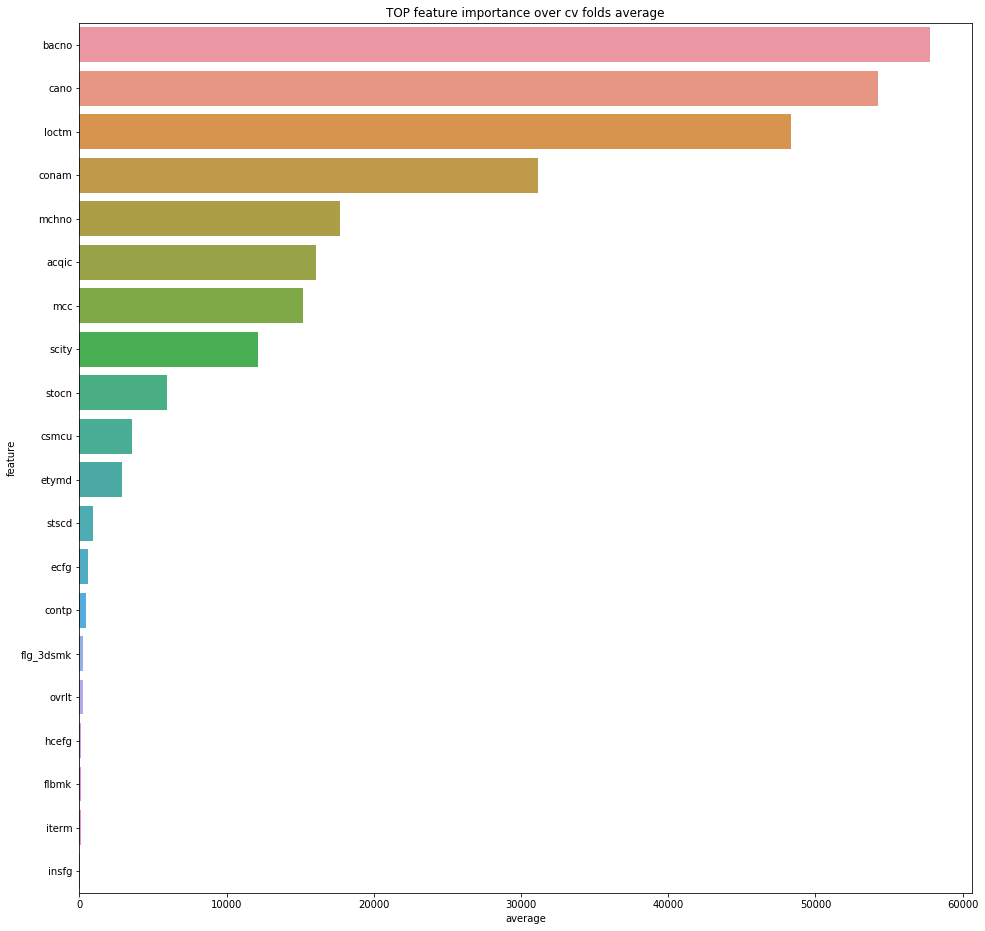

In [94]:
feature_importances['average'] = feature_importances.mean(axis=1)

plt.figure(figsize=(16, 16))
sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(30), x='average', y='feature')
plt.title('TOP feature importance over cv folds average');

In [95]:
# 结果保存
threshold = 0.5
predictions = [int(item>threshold) for  item in predictions]
sampleSubmission = pd.read_csv('submission_test_sample.csv')
sampleSubmission['fraud_ind'] = predictions
sampleSubmission.to_csv('submission_test.csv',index = None)

In [ ]:
threshold = 0.5
y_pre = [int(item>threshold) for  item in pred]
print( "  auc = ", roc_auc_score(y_valid_df, y_pre))
print( "  f1 = ", f1_score(y_valid_df, y_pre))
print( "  confusion_matrix = \r\n", confusion_matrix(y_valid_df, y_pre) )
#predictions += clf.predict(X_test) / splits